In [1]:
using LinearAlgebra
include("ALTROstructures.jl")
include("vehicledynamics.jl")
include("costfunction.jl")
include("ALiLQR.jl")
include("backwardpass.jl")
include("forwardpass.jl")
include("projection.jl")
include("projectionlinesearch.jl")


UPDATECONSTRAINTS (generic function with 1 method)

## ALTRO Hyperparameters 

In [2]:
# Hyperparameters
ilqr_params = Dict(
    # iLQR Hyperparameters
    :epsilon_cost => 1e-3,         # Cost tolerance
    :epsilon_grad => 1e-3,         # Gradient tolerance
    :max_iterations => 500,        # Max iterations
    :line_search_lb => 1e-4,       # Lower bound for line search
    :line_search_ub => 0.9,        # Upper bound for line search
    :line_search_max_iters => 20,  # Max line search iterations
    :rho_init => 1e-6,             # Initial regularization
    :rho_max => 1e-3,              # Max regularization
    :rho_min => 1e-6,              # Min regularization

    # Cost Function Parameters
    :Q => Diagonal([1.0, 1.0, 0.05, 0.05, 0.05, 0.05]),      # State cost weight matrix
    :R => Diagonal([0.1, 0.1]),                          # Control cost weight matrix
    :H => zeros(6, 2),                                   # Cross-term cost matrix
    :Qf => Diagonal([5.0, 5.0, 0.5, 0.5, 0.5, 0.5]),   # Terminal state cost weight matrix
    :Rs => Diagonal(fill(0.001, 6))                       # Slack cost weight matrix
)



al_params = Dict(
    :epsilon_cost => 1e-2,   # Outer loop cost tolerance
    :constraint_tol => 1e-2, # Constraint tolerance
    :penalty_scaling => 5.0,# Penalty scaling factor
    :penalty_init => 1e-3,   # Initial penalty
    :penalty_max => 1e-2,    # Max penalty
    :max_outer_iterations => 20 # Max outer iterations
)


# Desired trajectory
N = 10  # Number of steps
final_x = 80.0
final_y = 2.0
v = 25.0  # Desired velocity

# Compute Δt based on velocity and distance
Δt = (final_x / N) / v

# Step increment for x
Δx = final_x / N

# Generate the desired trajectory
X_desired = [i < N/2 ? [i * Δx, 0.0, v, 0.0, 0.0, 0.0] :
                        [i * Δx, final_y, v, 0.0, 0.0, 0.0] for i in 0:N]


# Pack into the constraints dictionary
constraints = Dict(
    :target_speed => 25.0,
    :target_position => [80.0, 2.0],
    :road_width => 6.0,
    :obstacle_position => [40.0, 2.0],
    :Qv => 1.0,  # Speed tracking weight
    :X_desired => X_desired # Add the desired trajectory
)



Dict{Symbol, Any} with 6 entries:
  :target_speed      => 25.0
  :obstacle_position => [40.0, 2.0]
  :road_width        => 6.0
  :X_desired         => [[0.0, 0.0, 25.0, 0.0, 0.0, 0.0], [8.0, 0.0, 25.0, 0.0,…
  :target_position   => [80.0, 2.0]
  :Qv                => 1.0

## Helper Functions to Initialize Trajectory

In [3]:
function infeasible_start(X_desired::Vector{Vector{Float64}}, U::Vector{Vector{Float64}}, Δt::Float64, l::Float64)
    """
    Compute slack variables for an infeasible start.

    Arguments:
    - X_desired: Desired state trajectory (array of vectors).
    - U: Control trajectory (array of vectors).
    - Δt: Time step duration.
    - l: Vehicle wheelbase.

    Returns:
    - X: Initial state trajectory (with dynamics corrections).
    - Slack: Slack variables for each time step as a vector of vectors.
    """
    N = length(U)                # Number of time steps
    nx = length(X_desired[1])    # State dimension
    Slack = [zeros(nx) for _ in 1:N]  # Initialize slack variables
    X = [X_desired[1]]           # Initialize state trajectory with the first state

    for k in 1:N
        # Compute the next state based on dynamics
        x_next_dynamics = vehicle_dynamics(X_desired[k], U[k], Δt, l)

        # Compute slack as the difference between desired and actual
        Slack[k] = X_desired[k+1] - x_next_dynamics

        # Update the next state in the trajectory
        push!(X, x_next_dynamics + Slack[k])
    end

    return X, Slack
end




infeasible_start (generic function with 1 method)

In [4]:
function initialize_feasible(X_desired::Vector{Vector{Float64}}, U::Vector{Vector{Float64}}, Δt::Float64, l::Float64)
    """
    Initialize a feasible trajectory from an infeasible one using slack controls.

    Arguments:
    - X_desired: Desired state trajectory (array of vectors).
    - U: Control trajectory (array of vectors).
    - Δt: Time step duration.
    - l: Vehicle wheelbase.

    Returns:
    - X: Feasible state trajectory.
    - S: Slack controls.
    """
    X, S = infeasible_start(X_desired, U, Δt, l)
    return X, S
end


initialize_feasible (generic function with 1 method)

In [5]:
function generate_X_desired(x0, U, Δt, l, N)
    X = [zeros(length(x0)) for _ in 1:N+1]
    X[1] = x0
    for k in 1:N
        X[k+1] = vehicle_dynamics(X[k], U[k], Δt, l)
    end
    return X
end


generate_X_desired (generic function with 1 method)

In [6]:
function initialize_trajectory(x0, U, X_desired, Δt, l, N)
    """
    Initialize the state trajectory and slack controls.

    Arguments:
    - x0: Initial state.
    - U: Initial control trajectory.
    - X_desired: Desired state trajectory (optional).
    - Δt: Time step duration.
    - l: Vehicle wheelbase.
    - N: Number of time steps.

    Returns:
    - X: Initial state trajectory (feasible or infeasible).
    - Slack: Slack variables for each time step as a vector of vectors.
    """
    # Generate X_desired if not provided
    if X_desired === nothing
        X_desired = generate_X_desired(x0, U, Δt, l, N)
    end

    # Compute initial trajectory and slack variables
    X, Slack = infeasible_start(X_desired, U, Δt, l)

     # Add terminal slack variable
     push!(Slack, zeros(size(Slack[1])))

    return X, Slack
end




initialize_trajectory (generic function with 1 method)

In [7]:
function compute_constraint_residuals(X, U, solver)
    """
    Compute the residuals of the constraints for the current state and control trajectories.

    Arguments:
    - X: State trajectory (array of state vectors).
    - U: Control trajectory (array of control vectors).
    - solver: Solver object containing dynamics and time-step information.

    Returns:
    - residuals: Vector of constraint residuals for all time steps.
    """
    N = solver.N  # Number of time steps
    residuals = []

    # Loop through all time steps
    for k in 1:N
        # Predicted next state using dynamics
        x_next_dynamics = vehicle_dynamics(X[k], U[k], solver.Δt, solver.l)

        # Residual: Difference between predicted and actual next state
        residual = X[k+1] - x_next_dynamics

        # Append residual to the list
        push!(residuals, residual)
    end

    # Flatten the list of residuals into a single vector
    return vcat(residuals...)
end


compute_constraint_residuals (generic function with 2 methods)

## Main ALTRO Algorithm 

In [8]:
function ALTRO(x0, U, X_desired, N, Δt, l, tol, al_params, ilqr_params, constraints)
    """
    Augmented Lagrangian Trajectory Optimization (ALTRO)

    Arguments:
    - x0: Initial state vector.
    - U: Initial control trajectory (array of vectors).
    - X_desired: Desired state trajectory.
    - N: Number of time steps.
    - Δt: Time step duration.
    - l: Vehicle wheelbase.
    - tol: Tolerance for convergence.
    - al_params: Dictionary of Augmented Lagrangian hyperparameters.
    - ilqr_params: Dictionary of iLQR hyperparameters.

    Returns:
    - X: Optimized state trajectory.
    - U: Optimized control trajectory.
    """
    state_history = []  # To store all states across iterations
    control_history = []  # To store all controls across iterations

    ρ = al_params[:penalty_init]  # Initialize penalty parameter

    # Extract iLQR hyperparameters
    epsilon_cost = ilqr_params[:epsilon_cost]
    epsilon_grad = ilqr_params[:epsilon_grad]
    max_iterations = ilqr_params[:max_iterations]
    line_search_lb = ilqr_params[:line_search_lb]
    line_search_ub = ilqr_params[:line_search_ub]
    line_search_max_iters = ilqr_params[:line_search_max_iters]
    rho_init = ilqr_params[:rho_init]
    rho_max = ilqr_params[:rho_max]
    rho_min = ilqr_params[:rho_min]

    # Extract cost function matrices
    Q = ilqr_params[:Q]
    R = ilqr_params[:R]
    H = ilqr_params[:H]
    Qf = ilqr_params[:Qf]
    Rs = ilqr_params[:Rs]

    println("Initializing solver")
    solver = iLQRSolver(
        N = N,
        D = [DynamicsExpansion(zeros(length(x0), length(x0)), zeros(length(x0), length(U[1]))) for _ in 1:N],
        Eerr = [CostExpansion(zeros(length(x0)), zeros(length(U[1])),
                              zeros(length(x0), length(x0)), zeros(length(U[1]), length(U[1])),
                              zeros(length(U[1]), length(x0))) for _ in 1:N],
        S = [CostToGo(zeros(length(x0)), zeros(length(x0), length(x0))) for _ in 1:N+1],
        Slack = [zeros(length(x0)) for _ in 1:N+1],  # Initialize Slack variables
        Q_expansion = [CostExpansion(zeros(length(x0)), zeros(length(U[1])),
                                     zeros(length(x0), length(x0)), zeros(length(U[1]), length(U[1])),
                                     zeros(length(U[1]), length(x0))) for _ in 1:N],
        K = [zeros(length(U[1]), length(x0)) for _ in 1:N],
        d = [zeros(length(U[1])) for _ in 1:N],
        Quu_reg = [zeros(length(U[1]), length(U[1])) for _ in 1:N],
        Qux_reg = zeros(length(U[1]), length(x0)),
        ΔV = ones(2),
        Qtmp = QtmpStruct(
            xx = zeros(length(x0), length(x0)),
            ux = zeros(length(U[1]), length(x0)),
            u = zeros(length(U[1]))
        ),
        reg = Regularization(ρ = al_params[:penalty_init]),
        opts = SolverOptions(bp_reg_type = :control),
        Q_cost = ilqr_params[:Q],
        R = ilqr_params[:R],
        H = ilqr_params[:H],
        Qf = ilqr_params[:Qf],
        Rs = ilqr_params[:Rs],
        q = zeros(length(x0)),
        r = zeros(length(U[1])),
        Δt = Δt,
        l = l
    )

    # Initialize trajectory and Slack variables
    println("Initializing trajectory")
    X, Slack = initialize_trajectory(x0, U, X_desired, Δt, l, N)
    println("Finished initializing trajectory")
    # Debugging output
    println("Size of solver.Slack: ", [size(s) for s in solver.Slack])
    println("Size of Slack: ", [size(s) for s in Slack])

    # Assign Slack values to solver
    if length(solver.Slack) == length(Slack)
        for k in 1:length(Slack)
            solver.Slack[k] .= Slack[k]
        end
    else
        error("Mismatch in dimensions: solver.Slack and Slack have incompatible sizes.")
    end
    λ_vals = [zeros(12) for _ in 1:N]  # Initialize Lagrange multipliers with correct size

    println("Initial X dimensions: ", [size(x) for x in X])
    println("Initial U dimensions: ", [size(u) for u in U])
    println("Slack variables dimensions: ", [size(s) for s in solver.Slack])
    println("Lagrange multipliers dimensions: ", [size(λ) for λ in λ_vals])


    J_prev = Inf  # Initialize J_prev to a high value
    println("Starting ALTRO optimization loop")
    for iter in 1:al_params[:max_outer_iterations]
        println("Iteration $iter")

        # AL-iLQR step
        println("Running AL-iLQR")
        X, U, J = AL_iLQR(X, U, solver.S, λ_vals, ρ, tol, solver, ilqr_params, constraints, al_params)
        println("Finished AL-iLQR in ALTRO")
        # Append current state and control trajectories
        push!(state_history, X)
        push!(control_history, U)


        # Projection step
        println("Running projection")
        X, U = projection(X, U, λ_vals, tol, solver, ilqr_params)
        println("Finished projection in ALTRO")

        # Initialize constraint_residuals
        constraint_residuals = Float64[]

        # Update Lagrange multipliers
        println("Updating Lagrange multipliers...")

        for k in 1:solver.N
            # Compute residuals for time step k
            g_k = compute_constraint_residuals_at_k(X, U, k, solver, constraints)
            println("Constraint residual dimensions at step $k: ", size(g_k))
            println("Lagrange multipliers before update at step $k: ", λ_vals[k])
            
            # Save residuals for global evaluation
            append!(constraint_residuals, g_k)  # Append g_k into the global residuals array

            # Update multipliers
            λ_vals[k] .= λ_vals[k] + solver.reg.ρ * g_k
            
            println("Lagrange multipliers after update at step $k: ", λ_vals[k])
        end

        println("All constraint residuals after update: ", constraint_residuals)

        # Adjust Penalty Scaling
        println("Adjusting penalty scaling...")
        if maximum(abs.(constraint_residuals)) > al_params[:constraint_tol]
            solver.reg.ρ *= al_params[:penalty_scaling]
            solver.reg.ρ = min(solver.reg.ρ, al_params[:penalty_max])
            println("Updated penalty parameter: ", solver.reg.ρ)
        else
            println("Penalty scaling unchanged. Maximum residual within tolerance.")
        end


        # Update Slack variables
        println("Updating Slack variables")
        for k in 1:N
            x_next_dynamics = vehicle_dynamics(X[k], U[k], Δt, l)
            solver.Slack[k+1] .= X_desired[k+1] - x_next_dynamics
        end

         # Check Convergence
        println("Checking convergence in ALTRO")
        ΔJ = abs(J - J_prev)  # Change in cost
        max_constraint_violation = maximum(abs.(constraint_residuals))

        if ΔJ < al_params[:epsilon_cost]
            println("ALTRO converged due to small cost change (ΔJ = $ΔJ) at iteration $iter.")
            println("Final cost J = $J")
            println("Max constraint violation: $max_constraint_violation")
            return X, U
        elseif max_constraint_violation < al_params[:constraint_tol]
            println("ALTRO converged due to constraint satisfaction at iteration $iter.")
            println("Final cost J = $J")
            println("Max constraint violation: $max_constraint_violation")
            return X, U
        end

        # Update J_prev for the next iteration
        J_prev = J

    end

    println("Failed to converge within the maximum iterations")
    # return X, U
    return state_history, control_history

end





ALTRO (generic function with 1 method)

In [9]:
# Initial state (x, y, v, a, θ, φ)
x0 = [0.0, 0.0, 25.0, 0.0, 0.0, 0.0]  

# Desired trajectory
N = 10  # Number of time steps

# Initial control trajectory (η, ω)
U = [[0.1, 0.05] for _ in 1:N]

# Simulation parameters
Δt = 0.1  # Time step
l = 2.5   # Vehicle wheelbase
tol = 1e-4  # Convergence tolerance

# Desired trajectory
X_desired = X_desired # see code above with the desired trajectory


11-element Vector{Vector{Float64}}:
 [0.0, 0.0, 25.0, 0.0, 0.0, 0.0]
 [8.0, 0.0, 25.0, 0.0, 0.0, 0.0]
 [16.0, 0.0, 25.0, 0.0, 0.0, 0.0]
 [24.0, 0.0, 25.0, 0.0, 0.0, 0.0]
 [32.0, 0.0, 25.0, 0.0, 0.0, 0.0]
 [40.0, 2.0, 25.0, 0.0, 0.0, 0.0]
 [48.0, 2.0, 25.0, 0.0, 0.0, 0.0]
 [56.0, 2.0, 25.0, 0.0, 0.0, 0.0]
 [64.0, 2.0, 25.0, 0.0, 0.0, 0.0]
 [72.0, 2.0, 25.0, 0.0, 0.0, 0.0]
 [80.0, 2.0, 25.0, 0.0, 0.0, 0.0]

In [10]:
# Run ALTRO
state_history, control_history = ALTRO(x0, U, X_desired, N, Δt, l, tol, al_params, ilqr_params, constraints)

Initializing solver
Initializing trajectory
Finished initializing trajectory
Size of solver.Slack: [(6,), (6,), (6,), (6,), (6,), (6,), (6,), (6,), (6,), (6,), (6,)]
Size of Slack: [(6,), (6,), (6,), (6,), (6,), (6,), (6,), (6,), (6,), (6,), (6,)]
Initial X dimensions: [(6,), (6,), (6,), (6,), (6,), (6,), (6,), (6,), (6,), (6,), (6,)]
Initial U dimensions: [(2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,)]
Slack variables dimensions: [(6,), (6,), (6,), (6,), (6,), (6,), (6,), (6,), (6,), (6,), (6,)]
Lagrange multipliers dimensions: [(12,), (12,), (12,), (12,), (12,), (12,), (12,), (12,), (12,), (12,)]
Starting ALTRO optimization loop
Iteration 1
Running AL-iLQR
Computing residuals for constraints at step 1...
Residuals dimensions: (12,)
Computing residuals for constraints at step 2...
Residuals dimensions: (12,)
Computing residuals for constraints at step 3...
Residuals dimensions: (12,)
Computing residuals for constraints at step 4...
Residuals dimensions: (12,)
Computing re

Excessive output truncated after 524329 bytes.


Residuals dimensions: (12,)
Computing residuals for constraints at step 7...
Residuals dimensions: (12,)
Computing residuals for constraints at step 8...
Residuals dimensions: (12,)
Computing residuals for constraints at step 9...
Residuals dimensions: (12,)
Computing residuals for constraints at step 10...
Residuals dimensions: (12,)
Actual vs Expected Cost Reduction: ΔV_actual = -0.0002457012888044119, ΔV_expected = -4.973588658210318e-6, z = 49.40120819980001
Line search failed: reducing step size.
Line Search Iteration 18: α = 6.866455078125e-6
Computing residuals for constraints at step 1...
Residuals dimensions: (12,)

(Any[[[0.0, 0.0, 25.0, 0.0, 0.0, 0.0], [8.0, 0.0, 25.0, 0.0, 0.0, 0.0], [16.0, 0.0, 25.0, 0.0, 0.0, 0.0], [24.0, 0.0, 25.0, 0.0, 0.0, 0.0], [32.0, 0.0, 25.0, 0.0, 0.0, 0.0], [40.0, 2.0, 25.0, 0.0, 0.0, 0.0], [48.0, 2.0, 25.0, 0.0, 0.0, 0.0], [56.0, 2.0, 25.0, 0.0, 0.0, 0.0], [64.0, 2.0, 25.0, 0.0, 0.0, 0.0], [72.0, 2.0, 25.0, 0.0, 0.0, 0.0], [80.0, 2.0, 25.0, 0.0, 0.0, 0.0]], [[0.0, 0.0, 25.0, 0.0, 0.0, 0.0], [2.5, 0.0, 25.0, -5.007532889588976, 0.0, -0.12631011816169788], [5.0, 0.0, 24.499246711041103, -7.999327777118738, -0.12698616035075092, -0.39862904367635577], [7.4301980892121176, -0.3102710770831799, 23.69931393332923, -9.873066639538441, -0.5397280404120107, -0.4775040022653711], [9.46324011812531, -1.528185243918208, 22.712007269375384, -10.824545525628874, -1.0302492855248555, -0.46928325115058744], [10.632011633367842, -3.4755747496923552, 21.629552716812498, -11.102479075150447, -1.4909074208796769, -0.5186215912978125], [10.80462401789367, -5.631631444680226, 20.519304809

20-element Vector{Any}:
 [[0.0, 0.0, 25.0, 0.0, 0.0, 0.0], [8.0, 0.0, 25.0, 0.0, 0.0, 0.0], [16.0, 0.0, 25.0, 0.0, 0.0, 0.0], [24.0, 0.0, 25.0, 0.0, 0.0, 0.0], [32.0, 0.0, 25.0, 0.0, 0.0, 0.0], [40.0, 2.0, 25.0, 0.0, 0.0, 0.0], [48.0, 2.0, 25.0, 0.0, 0.0, 0.0], [56.0, 2.0, 25.0, 0.0, 0.0, 0.0], [64.0, 2.0, 25.0, 0.0, 0.0, 0.0], [72.0, 2.0, 25.0, 0.0, 0.0, 0.0], [80.0, 2.0, 25.0, 0.0, 0.0, 0.0]]
 [[0.0, 0.0, 25.0, 0.0, 0.0, 0.0], [2.5, 0.0, 25.0, -5.007532889588976, 0.0, -0.12631011816169788], [5.0, 0.0, 24.499246711041103, -7.999327777118738, -0.12698616035075092, -0.39862904367635577], [7.4301980892121176, -0.3102710770831799, 23.69931393332923, -9.873066639538441, -0.5397280404120107, -0.4775040022653711], [9.46324011812531, -1.528185243918208, 22.712007269375384, -10.824545525628874, -1.0302492855248555, -0.46928325115058744], [10.632011633367842, -3.4755747496923552, 21.629552716812498, -11.102479075150447, -1.4909074208796769, -0.5186215912978125], [10.80462401789367, -5.631631444

(20,)

20-element Vector{Any}:
 [[0.1, 0.05], [0.1, 0.05], [0.1, 0.05], [0.1, 0.05], [0.1, 0.05], [0.1, 0.05], [0.1, 0.05], [0.1, 0.05], [0.1, 0.05], [0.1, 0.05]]
 Any[[-50.07532889588976, -1.2631011816169788], [-29.91794887529762, -2.723189255146579], [-18.737388624197024, -0.7887495858901532], [-9.514788860904332, 0.08220751114783661], [-2.7793354952157285, -0.49338340147224985], [1.8863795556939065, -1.4522815885388562], [4.902744606884905, -8.420612178455556], [6.286582337164398, -13.385854751620249], [5.852316645521034, 30.69772176596409], [4.453644506700056, -0.11852301593067739]]
 Any[[-54.311533560290975, -13.492933244414557], [-22.93556801680891, 2.068314513678675], [-18.155734282756118, 8.290716556610437], [-8.526788135953197, -0.52819788483012], [0.8683548167343882, -0.8180689545488367], [6.471908626977388, 1.8314053348257076], [9.339740790533673, -0.8488947879727162], [10.404330056477225, -1866.6212049526712], [5.647557484703098, 189.60256527137426], [3.4105232868648283, 80.007746

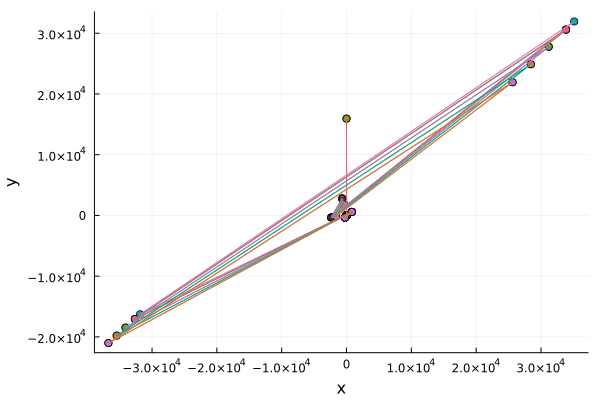

In [11]:
display(state_history)
display(size(state_history))
display(control_history)

using Plots

# Extract x and y coordinates from state_history
x = [state[1] for state in state_history]
y = [state[2] for state in state_history]

# Plot x vs y with points along the line
scatter(x, y, xlabel="x", ylabel="y", legend=false)
plot!(x, y)

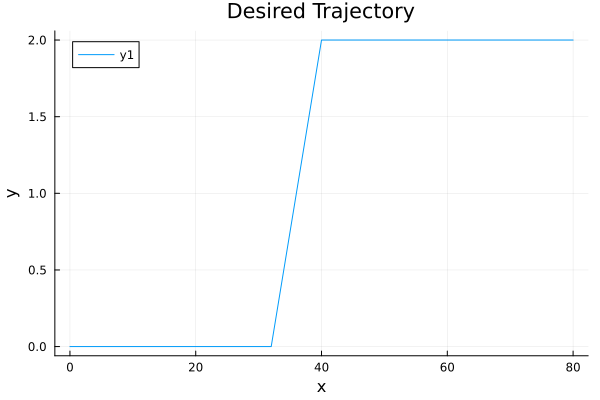

In [19]:
# Define the variables for the plot
x_desired = [state[1] for state in X_desired]
y_desired = [state[2] for state in X_desired]

# Plot x_desired vs y_desired with points along the line
plot(x_desired, y_desired, xlabel="x", ylabel="y", title="Desired Trajectory")
